# Human Activiry Recognition

## Project description

The goal of human activity recognition (HAR) is to take an advantage of accelerometer and gyroscope sensors data e.g. from your smartphone and classify these data to predict specific type of movement sych as walking, running, sitting etc.

Accelerometers and gyroscopes are device capable of measuring mass acceleration and angular rotation. Depending on  type and quality of the sensor, accelerometer data can be very noisy and biased, which can introduce additional errors in our model.

In general, HAR is challenging tasks, due to the large number of data that accelerometers generates (easily up to 200Hz) every second, noisy data as well as the fact that there is no clear way to relate accelerometer data to specific movements.

Since, the original data source created by **[UCI](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)** is not functional anymore, for this project we will use the copy of dataset downloaded from Kaggle data repository **[KAGGLE DATA SET](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones)**

## Setup the environment

First, let's import necessary modules and setup working environment. We also include function for saving figures. 

In [149]:
# import dependencies
import sys
assert sys.version_info >= (3,5)
import os
import urllib
import time, datetime
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd
import math, random

# Data visualization
import missingno
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib as mpl
import matplotlib.ticker as ticker
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.pyplot as plt
# plt.style.use("seaborn-whitegrid")

# Machine learning
import sklearn
assert sklearn.__version__ >= "0.20" # check Scikit-learn version 
from sklearn import model_selection, preprocessing, metrics, linear_model, tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Define constants and variables
PROJECT_ROOT_DIR = '.'
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATA_PATH, exist_ok=True)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saveing figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load the data

The data were downloaded from the Kaggle data repository (see the link above in project description) and saved into project folder.

**TBD**: add data description

In [61]:
def load_data(data_path=DATA_PATH):
    try:
        train_set = pd.DataFrame(pd.read_csv(os.path.join(data_path, "train.csv")))
        test_set  = pd.DataFrame(pd.read_csv(os.path.join(data_path, "test.csv")))
        print("Data set {0} and {1} were loaded.".format("train.csv", "test.csv"))
        return train_set, test_set
#     except IOError:
#             print("Data set not found.")
    except FileNotFoundError:
        print("Data set was not found.")

In [62]:
# load the data 
train, test = load_data()
# create new data frames df_train and df_test, 
# so we don't touch the original data
df_train = train
df_test = test

Data set train.csv and test.csv were loaded.


## Data description

Data in the dataset were recorded using a buiil in smartphone accelerometer and gyroscope sensors, which captured 3-axial linear acceleration and 3-axial angular velocity with logging (sampling) frequency of 50Hz. Sensor data are already-preprocessed.

More details about how the data were recored, labeled, and pre-processed please refer to the original **[UCI data repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)**.

In [63]:
# View the train data
print("Train data set size is {}".format(train.shape))

Train data set size is (7352, 563)


As we can see there are 563 columns in dataset. After closer look, you will notice the features are dvided into few categories (acceleration, gravity) with some additional parameter (mean, std, ...).
Let's group and count the main categories together. This will give us better data overview.

In [64]:
def group_data_columns(data_set):
    """
    Function takes data set as an input argument and returns new data frame, 
    where the first column represents the attribute's name and seconds its count
    value from original dataset.
    
    :: param_data_set = input data frame
    """
    # Group and count main names of columns
    grouped_columns = pd.DataFrame.from_dict(Counter([column.split('-')[0].split('(')[0] for column in data_set.columns]), orient='index')
    grouped_columns.rename(columns={0:'count'}, inplace=True) # rename the columns 0 to count
    grouped_columns.sort_values('count', ascending=False) # order the rows in descending fashion
    return grouped_columns

In [65]:
group_data_columns(train)

,count
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyro,40
tBodyGyroJerk,40
tBodyAccMag,13
tGravityAccMag,13
tBodyAccJerkMag,13
tBodyGyroMag,13
tBodyGyroJerkMag,13


From the table above, we can distinguish between two main attributes, starting with letter "t" and "f", which means sensor data obtained in time and frequency domain, respectively. Both time and frequency domains have subcategories such as acceleration and gravity.

## Explore missing values

Let's explore if the data set contains missing values (gaps). If there are no data you cannot make predictions. The goal is to fill the gaps.

In [66]:
# function that detects and plot missing values
def find_missing_values(data_set, columns, plot_figure=False):
    """
    Find a number of rows where certain column values are missing.
    :: param_data_set = target dataframe
    :: param_columns = list of columns
    :: param_plot_figure = plot missing values plot
    """
    # TODO: replace missing_values with data frame. 
    #       Use this dataframe to plot missingno figure.
    
    missing_values = {}
    data_length = len(data_set)
    for column in columns:
        total_column_values = data_set[column].value_counts().sum()
        missing_value = data_length - total_column_values
        if missing_value > 0: # store only columns with missing values
            missing_values[column] = missing_value
    if len(missing_values) > 0:
        print("Number of missing or NaN values for each column: {0}".format(pd.DataFrame.from_dict(missing_values)))
    else:
        print("There are no missing values in data set.")    
    if (plot_figure and len(missing_values)>0):
        # Convert missing_values dict to DataFrame and plot
        missingno.matrix(pd.DataFrame.from_dict(missing_values), figsize=(20,5))
    return missing_values

In [67]:
train_missing_values = find_missing_values(train, columns=train.columns, plot_figure=True)  

There are no missing values in data set.


In [68]:
test_missing_values = find_missing_values(test, columns=test.columns, plot_figure=False)

There are no missing values in data set.


Exploration of missing values in train and test data set showed that there are no missing values or gaps.

## What data types are in the dataframe?

Features with a data type of object can be considered categorical features. Features with a data type of float or int could be considered as numerical.

Ideally, we want all features to be encoded into numerical value of some kind.

In [69]:
def disp_dataset_dtype(data_set, data_set_name=None, verbose=False):
    """
    :: param_data_set_name = name of the data set
    :: param_data_set = input data set
    :: param_verbose = display data type for ach column
    """  
    print("Data types in {0} data frame:\n".format(data_set_name))
    return data_set.info(verbose=verbose)

In [70]:
disp_dataset_dtype(data_set=train, data_set_name="train.csv")

Data types in train.csv data frame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [71]:
disp_dataset_dtype(data_set=test, data_set_name="test.csv")

Data types in test.csv data frame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


Both test and train data set have only  numerical data of type float and int. Only the label "Activity", feature we want to predict, is type of object (string) and it is a cetegorical variable. For a better data manipulation let's create a new numerical label **"Activity_num"**.

In [72]:
df_train["Activity"].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [73]:
df_train["Activity_num"] = df_train["Activity"].astype("category").cat.codes
df_train["Activity_num"].value_counts()

0    1407
2    1374
1    1286
3    1226
5    1073
4     986
Name: Activity_num, dtype: int64

**Label: Activity_num**

Description: Type of movement
Key: 0 = Laying,
     1 = Standing,
     2 = Sitting,
     3 = Walking,
     4 = Walking_upstairs,
     5 = Walking_downstairs,

## Activity label exploration

Let's look at the distribution of "Activity" label in our data set.

Saveing figure  Activity_distribution


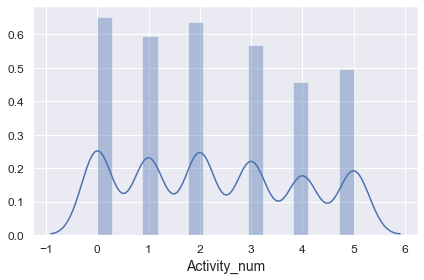

In [74]:
sns.distplot(df_train["Activity_num"])
save_fig("Activity_distribution")

Saveing figure  activity_dsitribution


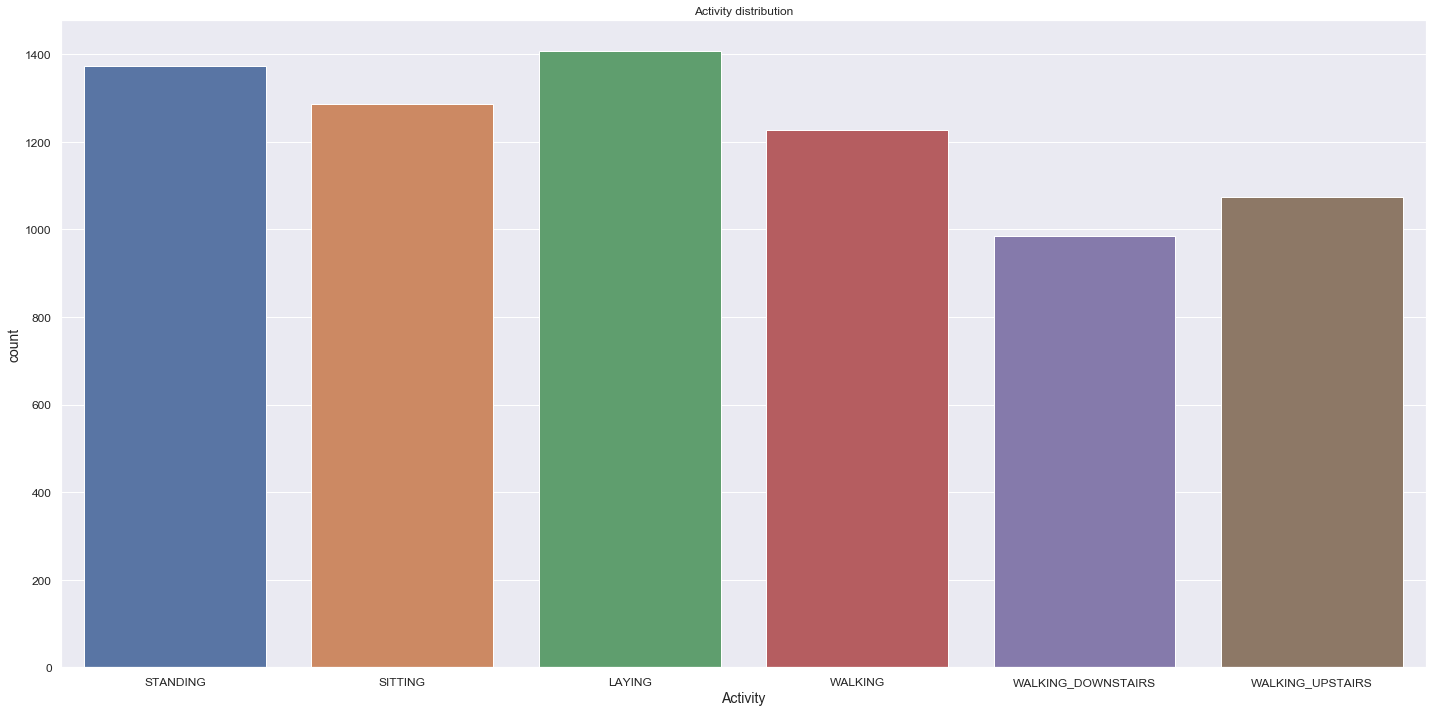

In [75]:
# Lets view the distribution of Sex feature
plt.figure(figsize=(20,10))
sns.countplot(x="Activity", data=df_train).set_title("Activity distribution")
save_fig("activity_dsitribution")

## Machine learning model

Prepare training data for machine learning algorithm.
There is no need to use LabelEncoder since we encoded target labels with numerical values in section above.

In [76]:
# Select the dataframe we want to use first for predictions
selected_df_train = df_train
X_train = selected_df_train.drop(["Activity","Activity_num"],axis=1) # training data
y_train = selected_df_train["Activity_num"] # lables

In [209]:
# define function that runs the requested machine learning algorithm 
# and returs the accuracy metrics

def fit_ml_algorithm(ml_algo, X_train, y_train, cv):
    
    # Fit the data
    model = ml_algo.fit(X_train, y_train)
    accuracy = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross-validation
    train_predictions = model_selection.cross_val_predict(ml_algo,
                                                           X_train,
                                                           y_train,
                                                           cv=cv,
                                                           n_jobs=-1)
    # Cross-validation accuracy metrics
    accuracy_cv = round(metrics.accuracy_score(y_train, train_predictions) * 100, 2)  
    return train_predictions, accuracy, accuracy_cv

In [210]:
from sklearn.metrics import precision_score, recall_score, f1_score
def precision_recall_f1(y_train, train_predictions, average="weighted"):
    """
    Function computes precision/recall/f1 scores of the classifier
    """
    precision = precision_score(y_train, train_predictions, average=average)
    recall = recall_score(y_train, train_predictions, average="weighted")
    f1 = f1_score(y_train, train_predictions, average="weighted")
    
    return precision, recall, f1

### Logistic Regression

In [214]:
# Logistic regression
start_time = time.time()
train_predictions_log, accuracy_log, accuracy_cv_log = fit_ml_algorithm(LogisticRegression(),
                                                     X_train,
                                                     y_train,
                                                     cv=10)
precision_log, recall_log, f1_log = precision_recall_f1(y_train, train_predictions_log)
log_time = (time.time() - start_time)
print("Accuracy: %s." % accuracy_log)
print("Accuracy CV 10-Fold: %s." % accuracy_cv_log)
print("Precision: %.2f." % precision_log)
print("Recall: %.2f." % recall_log)
print("F1: %.2f." % f1_log)
print("Running time: %s." % datetime.timedelta(seconds=log_time))

Accuracy: 98.83.
Accuracy CV 10-Fold: 93.72.
Precision: 0.94.
Recall: 0.94.
F1: 0.94.
Running time: 0:00:17.632215.


### K-Nearest Neighbours

In [215]:
# KNN
start_time = time.time()
train_predictions_knn, accuracy_knn, accuracy_cv_knn = fit_ml_algorithm(KNeighborsClassifier(),
                                                                       X_train,
                                                                       y_train,
                                                                        cv=10)
precision_knn, recall_knn, f1_knn = precision_recall_f1(y_train, train_predictions_knn)
knn_time = (time.time() - start_time)
print("Accuracy: %s." % accuracy_knn)
print("Accuracy CV 10-Fold: %s." % accuracy_cv_knn)
print("Precision: %.2f." % precision_knn)
print("Recall: %.2f." % recall_knn)
print("F1: %.2f." % f1_knn)
print("Running time: %s." % datetime.timedelta(seconds=knn_time))

Accuracy: 98.9.
Accuracy CV 10-Fold: 82.7.
Precision: 0.83.
Recall: 0.83.
F1: 0.83.
Running time: 0:00:25.063922.


### Gaussian Naive Bayes Classifier

In [216]:
# Gaussian Naive Bayes
start_time = time.time()
train_predictions_gauss, accuracy_gauss, accuracy_cv_gauss = fit_ml_algorithm(GaussianNB(),
                                                                       X_train,
                                                                       y_train,
                                                                        cv=10)
precision_gauss, recall_gauss, f1_gauss = precision_recall_f1(y_train, train_predictions_gauss)
gauss_time = (time.time() - start_time)
print("Accuracy: %s." % accuracy_gauss)
print("Accuracy CV 10-Fold: %s." % accuracy_cv_gauss)
print("Precision: %.2f." % precision_gauss)
print("Recall: %.2f." % recall_gauss)
print("F1: %.2f." % f1_gauss)
print("Running time: %s." % datetime.timedelta(seconds=gauss_time))

Accuracy: 75.16.
Accuracy CV 10-Fold: 70.29.
Precision: 0.76.
Recall: 0.70.
F1: 0.71.
Running time: 0:00:02.196476.


### Linear Support Vector Machine (SVC)

In [217]:
# Linear SVC
start_time = time.time()
train_predictions_linear_svc, accuracy_linear_svc, accuracy_cv_linear_svc = fit_ml_algorithm(LinearSVC(),
                                                                       X_train,
                                                                       y_train,
                                                                        cv=10)
precision_linear_svc, recall_linear_svc, f1_linear_svc = precision_recall_f1(y_train, train_predictions_linear_svc)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s." % accuracy_linear_svc)
print("Accuracy CV 10-Fold: %s." % accuracy_cv_linear_svc)
print("Precision: %.2f." % precision_linear_svc)
print("Recall: %.2f." % recall_linear_svc)
print("F1: %.2f." % f1_linear_svc)
print("Running time: %s." % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 99.43.
Accuracy CV 10-Fold: 94.9.
Precision: 0.95.
Recall: 0.95.
F1: 0.95.
Running time: 0:00:45.261485.


### Stochastic Gradient Classifier

In [218]:
start_time = time.time()
train_predictions_sgd, accuracy_sgd, accuracy_cv_sgd = fit_ml_algorithm(SGDClassifier(),
                                                                       X_train,
                                                                       y_train,
                                                                        cv=10)
precision_sgd, recall_sgd, f1_sgd = precision_recall_f1(y_train, train_predictions_sgd)
sgd_time = (time.time() - start_time)
print("Accuracy: %s." % accuracy_sgd)
print("Accuracy CV 10-Fold: %s." % accuracy_cv_sgd)
print("Precision: %.2f." % precision_sgd)
print("Recall: %.2f." % recall_sgd)
print("F1: %.2f." % f1_sgd)
print("Running time: %s." % datetime.timedelta(seconds=sgd_time))

Accuracy: 98.42.
Accuracy CV 10-Fold: 92.94.
Precision: 0.93.
Recall: 0.93.
F1: 0.93.
Running time: 0:00:10.161340.


### Decision Tree Classifier

In [219]:
# Decision Tree classifier
start_time = time.time()
train_predictions_dt, accuracy_dt, accuracy_cv_dt = fit_ml_algorithm(DecisionTreeClassifier(),
                                                                       X_train,
                                                                       y_train,
                                                                        cv=10)
precision_dt, recall_dt, f1_dt = precision_recall_f1(y_train, train_predictions_dt)
dt_time = (time.time() - start_time)
print("Accuracy: %s." % accuracy_dt)
print("Accuracy CV 10-Fold: %s." % accuracy_cv_dt)
print("Precision: %.2f." % precision_dt)
print("Recall: %.2f." % recall_dt)
print("F1: %.2f." % f1_dt)
print("Running time: %s." % datetime.timedelta(seconds=dt_time))

Accuracy: 100.0.
Accuracy CV 10-Fold: 84.51.
Precision: 0.85.
Recall: 0.85.
F1: 0.85.
Running time: 0:00:20.506423.


### Model performance analysis

Let's take a look at the regular and cross-validation accuracy, precision/recall/f1 scores of the models trained above.

We care more about cross-validation accuracy since the accuracy from .fit() method can randomly score higher than usual.
On the other hand, precission gives us an information how often the classifier is correct. Recall gives us an information how many instances of a class were correctly identified.

In [229]:
ml_models = pd.DataFrame({
    "ML Model" : ["Logistic Regression", "KNN", "Naive Bayes","Linear SVC",
                  "Stochastic Gradient","Decision Tree"],
    "Regular Score" : [accuracy_log,
                      accuracy_knn,
                      accuracy_gauss,
                      accuracy_linear_svc,
                      accuracy_sgd,
                      accuracy_dt
                      ],
    "CV score" : [accuracy_cv_log,
                      accuracy_cv_knn,
                      accuracy_cv_gauss,
                      accuracy_cv_linear_svc,
                      accuracy_cv_sgd,
                      accuracy_cv_dt],
    "Precision" : [precision_log,
                   precision_knn,
                   precision_gauss,
                   precision_linear_svc,
                   precision_sgd,
                   precision_dt
                  ],
    "Recall" : [recall_log,
                recall_knn,
                recall_gauss,
                recall_linear_svc,
                recall_sgd,
                recall_dt
               ],    
    "F1 score" : [f1_log,
                  f1_knn,
                  f1_gauss,
                  f1_linear_svc,
                  f1_sgd,
                  f1_dt
                 ]
})
print("--- Machine learning models and their regular and cross-validation scores ----")
ml_models.sort_values(by="F1 score", ascending=False)

--- Machine learning models and their regular and cross-validation scores ----


,ML Model,Regular Score,CV score,Precision,Recall,F1 score
3,Linear SVC,99.43,94.90,0.949111,0.948993,0.949027
0,Logistic Regression,98.83,93.72,0.937317,0.937160,0.937211
4,Stochastic Gradient,98.42,92.94,0.929719,0.929407,0.929441
5,Decision Tree,100.00,84.51,0.845377,0.845076,0.845104
1,KNN,98.90,82.70,0.831248,0.826986,0.826426
2,Naive Bayes,75.16,70.29,0.758361,0.702938,0.707437


From the first performance analysis we can see that linear support vector machine model performs the best. We will choose this model for the further use.

## Confusion matrix and error matrix

The better way to evaluate performance of the classifier is to use confusion matrix. General idea of the confusion matrix is to count number of times instances of class A are classified as class B.
The activities the model tries to predicts are as follows:

* LAYING                1407
* STANDING              1374
* SITTING               1286
* WALKING               1226
* WALKING_UPSTAIRS      1073
* WALKING_DOWNSTAIRS     986

In [226]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, train_predictions_linear_svc)
conf_mx
# df_train["Activity"].value_counts()

array([[1404,    1,    0,    0,    2,    0],
       [   8, 1199,   78,    0,    0,    1],
       [   0,   77, 1295,    2,    0,    0],
       [   0,    0,    0, 1158,    8,   60],
       [   0,    0,    0,    9,  936,   41],
       [   0,   12,    0,   31,   45,  985]], dtype=int64)

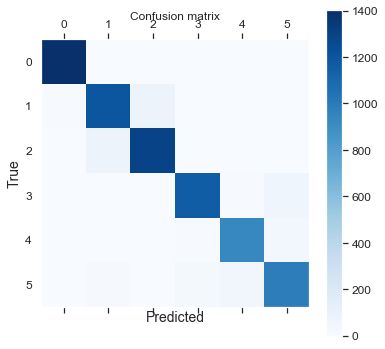

Saveing figure  confusion_matrix


<Figure size 432x288 with 0 Axes>

In [231]:
def plot_confusion_matrix(matrix, title="Confusion matrix", labels=None, cmap=plt.cm.Blues):
    """
    :: param_matrix = confusion matrix
    :: param_title = title of confusion matrix plot
    :: param_verbose = display data type for ach column
    :: param_cmap = color map scheme
    """ 
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)    
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.grid(False)
    plt.show()
    save_fig("confusion_matrix", tight_layout=False)    

plot_confusion_matrix(conf_mx)

To get the overview of the error rates we will construct error matrix by dividing each value in the confusion matrix by the number of instances of the corresponding class. This way, we can compare error rates instead of absolute number of errors.

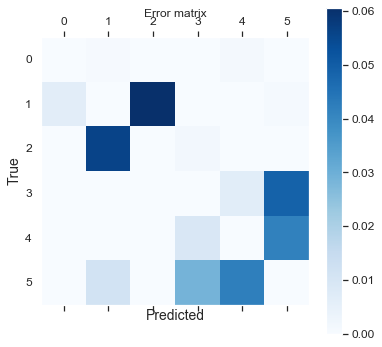

Saveing figure  error_matrix


<Figure size 432x288 with 0 Axes>

In [232]:
def plot_error_matrix(matrix, title="Error matrix", labels=None, cmap=plt.cm.Blues):
    """
    :: param_matrix = confusion matrix
    :: param_title = title of error matrix plot
    :: param_verbose = display data type for ach column
    :: param_cmap = color map scheme
    """ 
    fig = plt.figure(figsize=(6,6))
    rows_sums = matrix.sum(axis=1, keepdims=True) 
    norm_conf_mx = matrix / rows_sums
    np.fill_diagonal(norm_conf_mx, 0)
    ax = fig.add_subplot(111)
    cax = ax.matshow(norm_conf_mx, cmap=cmap)
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.grid(False)
    plt.show()
    save_fig("error_matrix", tight_layout=False)    

plot_error_matrix(conf_mx)